In [1]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math
import random as rn

# DataCollapse

In [2]:
import numpy as np

class DataCollapse:
    """DataCollapse class, use lmfit"""
    def __init__(self,df,p_,L_,params={'Metrics':'O',},p_range=[-0.1,0.1],Lmin=None,Lmax=None,adaptive_func=None):
        """ Perform Finite size scaling following the scaling form y~L^{-beta/nu} f[(p-p_c)L^{1/nu}], where `f` is a universal scaling function, and `y` is the observable.

        Parameters
        ----------
        df : DataFrame
            The DataFrame containing the data containing multiindex with at least `p_` and `L_` as the level names
        p_ : String
            Tuning parameter name, such as measurement rate `p`, temperature `T`, magnetic field `B`, etc.
        L_ : String
            System size name, such as system size `L`, time `t`, etc.
        params : dict, optional
            Other parameters to fix, by default {'Metrics':'O',}
        p_range : list, optional
            Range of tuning parameter, by default [-0.1,0.1]
        Lmin : Int, optional
            Minimal length L, by default None
        Lmax : Int, optional
            Minimal length L, by default None
        adaptive_func : function, optional
            Arbitary way to select data, by default None
        """
        self.p_range=p_range
        self.Lmin=0 if Lmin is None else Lmin
        self.Lmax=1000 if Lmax is None else Lmax
        self.params=params
        self.p_=p_
        self.L_=L_
        self.adaptive_func=adaptive_func

        self.df=self.load_dataframe(df,params)
        self.L_i,self.p_i,self.d_i,self.y_i = self.load_data()
    
    def load_dataframe(self,df,params,):
        if params is None or len(params)==0:
            df=df['observations']
        else:
            df=df.xs(params.values(),level=list(params.keys()))['observations']
        df=df[(df.index.get_level_values(self.L_)<=self.Lmax) & (self.Lmin<=df.index.get_level_values(self.L_))]
        if self.adaptive_func is None:
            df=df[(df.index.get_level_values(self.p_)<=self.p_range[1]) & (self.p_range[0]<=df.index.get_level_values(self.p_))]
        else:
            val=self.adaptive_func(df.index.get_level_values(self.p_),df.index.get_level_values(self.L_))
            df=df[(val <=self.p_range[1]) & (self.p_range[0]<=val)]
            
        return df.sort_index(level=[self.L_,self.p_])

    def load_data(self):
        L_i=(self.df.index.get_level_values(self.L_).values)
        p_i=(self.df.index.get_level_values(self.p_).values)
        d_i=(self.df.apply(np.std).values)/np.sqrt(self.df.apply(len).values)
        # d_i=(self.df.apply(np.std).values)
        y_i=(self.df.apply(np.mean).values)
        assert np.unique(p_i).shape[0]>=4, f'not enough data points {np.unique(p_i).shape[0]}'
        return L_i,p_i,d_i,y_i   

    
    def loss(self,p_c,nu,beta=0):
        """ y~L^{-beta/nu} f((p-p_c)L^{1/nu})"""
        x_i=(self.p_i-p_c)*(self.L_i)**(1/nu)
        order=x_i.argsort()
        x_i_ordered=x_i[order]
        y_i_ordered=self.y_i[order] * self.L_i[order]**(beta/nu)
        d_i_ordered=self.d_i[order] * self.L_i[order]**(beta/nu)
        x={i:x_i_ordered[1+i:x_i_ordered.shape[0]-1+i] for i in [-1,0,1]}
        d={i:d_i_ordered[1+i:d_i_ordered.shape[0]-1+i] for i in [-1,0,1]}
        y={i:y_i_ordered[1+i:y_i_ordered.shape[0]-1+i] for i in [-1,0,1]}
        x_post_ratio=(x[1]-x[0])/(x[1]-x[-1])
        x_pre_ratio=(x[-1]-x[0])/(x[1]-x[-1])
        y_var=d[0]**2+(x_post_ratio*d[-1])**2+(x_pre_ratio*d[1])**2
        y_var=np.clip(y_var,y_var[y_var>0].min(),None)
        y_bar=x_post_ratio*y[-1]-x_pre_ratio*y[1]
        # return y[0],y_bar,y_var
        return (y[0]-y_bar)/np.sqrt(y_var)

    def loss_with_drift(self,p_c,nu,y,b1,b2,a):
        """p_c: critical point
        nu: relevent critical exponent
        y: irrelevant scaling function
        b1: b1=[b10=0,b11,b12,...] in relevent part , b1.shape=(m1,)
        b2: b2=[b20,b21,b22,...] in irrelevant part, b2.shape=(m2+1,)
        a: a=[[a00, a01=1, a02, a03, ...],
            [a10=1, a11, a12, a13, ...],
            [a20, a21,   a22, a23, ...],
            ...]
        w_i.shape=(n_sample,)
        """
        w_i=((self.p_i-p_c))
        # w_i=((self.p_i-p_c)/p_c)
        u1_i=(b1)@w_i**np.arange(len(b1))[:,np.newaxis]    # (n_sample,) because b10=0 to ensure u1(w=0)=0
        u2_i=(b2)@w_i**np.arange(len(b2))[:,np.newaxis]  # (n_sample,)
        phi_1=u1_i*(self.L_i)**(1/nu)    # (n_sample,)
        phi_2=u2_i*(self.L_i)**(-y)  # (n_sample,)
        self.phi_1_=phi_1 ** np.arange(a.shape[0])[:,np.newaxis]    # (n1+1,n_sample)
        self.phi_2_=phi_2 ** np.arange(a.shape[1])[:,np.newaxis]    # (n2+1,n_sample)
        self.a=a
        self.y_i_fitted=np.einsum('ij,ik,kj->j',self.phi_1_,self.a,self.phi_2_)
        
        return (self.y_i-self.y_i_fitted)/self.d_i
    
    def datacollapse(self,p_c=None,nu=None,beta=None,p_c_vary=True,nu_vary=True,beta_vary=False,nu_range=(.5,2),p_c_range=(0,1),beta_range=(0,1),**kwargs):
        """data collapse without drift, x_i=(p_i-p_c)L^{1/nu}, and try to make x_i vs y_i collapse to a smooth line
        when beta exist, y_i is scaled by L^{beta/nu}"""
        from lmfit import minimize, Parameters

        params=Parameters()
        params.add('p_c',value=p_c,min=p_c_range[0],max=p_c_range[1],vary=p_c_vary)
        params.add('nu',value=nu,min=nu_range[0],max=nu_range[1],vary=nu_vary)
        params.add('beta',value=beta,min=beta_range[0],max=beta_range[1],vary=beta_vary)
        def residual(params):
            p_c,nu, beta=params['p_c'],params['nu'], params['beta']
            return self.loss(p_c,nu,beta)

        res=minimize(residual,params,**kwargs)
        self.p_c=res.params['p_c'].value
        self.nu=res.params['nu'].value
        self.beta=res.params['beta'].value
        self.res=res
        return res

    def datacollapse_with_drift(self,m1,m2,n1,n2,p_c=None,nu=None,y=None,b1=None,b2=None,a=None,p_c_vary=True,nu_vary=True,p_c_range=(0,1),y_vary=True,seed=None,**kwargs):
        from lmfit import minimize, Parameters

        params=Parameters()
        params.add('p_c',value=p_c,min=p_c_range[0],max=p_c_range[1],vary=p_c_vary)
        params.add('nu',value=nu,min=0,max=3,vary=nu_vary)
        params.add('y',value=y,min=0,vary=y_vary)
        rng=np.random.default_rng(seed)
        if b1 is None:
            # b1=[0]*(m1+1)
            b1=rng.normal(size=(m1+1))
        if b2 is None:
            # b2=[0]*(m2+1)
            b2=rng.normal(size=(m2+1))
        if a is None:
            # a=np.array([[0]*(n2+1)]*(n1+1))
            a=rng.normal(size=(n1+1,n2+1))
        for i in range(m1+1):
            if i == 0:
                params.add(f'b_1_{i}',value=0,vary=False)
            else:
                params.add(f'b_1_{i}',value=b1[i])
        for i in range(m2+1):
            params.add(f'b_2_{i}',value=b2[i])
        for i in range(n1+1):
            for j in range(n2+1):
                if (i==1 and j==0) or (i==0 and j==1):
                    params.add(f'a_{i}_{j}',value=1,vary=False)
                else:
                    params.add(f'a_{i}_{j}',value=a[i,j])
        def residual(params):
            return self.loss_with_drift(params['p_c'],params['nu'],params['y'],[params[f'b_1_{i}'] for i in range(m1+1)],[params[f'b_2_{i}'] for i in range(m2+1)],np.array([[params[f'a_{i}_{j}'] for j in range(n2+1)] for i in range(n1+1)]))
        res=minimize(residual,params,**kwargs)
        self.p_c=res.params['p_c'].value
        self.nu=res.params['nu'].value
        self.y=res.params['y'].value
        self.res=res

        self.x_i=(self.p_i-self.p_c)*(self.L_i)**(1/nu)
        
        self.y_i_minus_irrelevant=self.y_i-np.einsum('ij,ik,kj->j',self.phi_1_,self.a[:,1:],self.phi_2_[1:,:])
        return res
    
    def loss_with_drift_GLS(self,p_c,nu,y,n1,n2):
        x_i=(self.p_i-p_c)*(self.L_i)**(1/nu)
        ir_i=self.L_i**(-y) # irrelevant scaling
        j1,j2=np.meshgrid(np.arange(n1+1),np.arange(n2+1),indexing='ij')
        self.X=(x_i**j1.flatten()[:,np.newaxis] * ir_i**j2.flatten()[:,np.newaxis]).T
        Y=self.y_i
        Sigma_inv=np.diag(1/self.d_i**2)
        XX=self.X.T@ Sigma_inv @ self.X
        XY=self.X.T@ Sigma_inv @ Y
        self.beta=np.linalg.inv(XX)@XY
        self.y_i_fitted=self.X @ self.beta
        return (self.y_i-self.y_i_fitted)/self.d_i

    
    def datacollapse_with_drift_GLS(self,n1,n2,p_c=None,nu=None,y=None,p_c_range=(0,1),nu_range=(0,2),p_c_vary=True,nu_vary=True,**kwargs):
        """fit the coefficient of the taylor expansion of the scaling function, using generalized least square"""
        from lmfit import minimize, Parameters

        params=Parameters()
        params.add('p_c',value=p_c,min=p_c_range[0],max=p_c_range[1],vary=p_c_vary)
        params.add('nu',value=nu,min=nu_range[0],max=nu_range[1],vary=nu_vary)
        params.add('y',value=y,min=0)

        def residual(params):
            return self.loss_with_drift_GLS(params['p_c'],params['nu'],params['y'],n1,n2)
        res=minimize(residual,params,**kwargs)
        self.p_c=res.params['p_c'].value
        self.nu=res.params['nu'].value
        self.y=res.params['y'].value
        self.res=res
        self.x_i=(self.p_i-self.p_c)*(self.L_i)**(1/nu)
        if n2>0:
            self.y_i_minus_irrelevant=self.y_i- self.X.reshape((-1,n1+1,n2+1))[:,:,1:].reshape((-1,(n1+1)*n2))@self.beta.reshape((n1+1,n2+1))[:,1:].flatten()
            self.y_i_irrelevant=self.X.reshape((-1,n1+1,n2+1))[:,:,1:].reshape((-1,(n1+1)*n2))@self.beta.reshape((n1+1,n2+1))[:,1:].flatten()
        else:
            self.y_i_minus_irrelevant=self.y_i
            self.y_i_irrelevant=0
        self.res=res
        return res
        



    def plot_data_collapse(self,ax=None,drift=False,driftcollapse=False,plot_irrelevant=True,errorbar=False,abs=False,color_iter=None,**kwargs):
        import matplotlib.pyplot as plt
        x_i=(self.p_i-self.p_c)*(self.L_i)**(1/self.nu)
        y_i= self.y_i*self.L_i**(self.beta/self.nu)
        d_i = self.d_i * self.L_i**(self.beta/self.nu)
        # x_i=self.p_i
        if ax is None:
            fig,ax = plt.subplots()
        L_list=self.df.index.get_level_values(self.L_).unique().sort_values().values
        idx_list=[0]+(np.cumsum([self.df.xs(key=L,level=self.L_).shape[0] for L in L_list])).tolist()
        L_dict={L:(start_idx,end_idx) for L,start_idx,end_idx in zip(L_list,idx_list[:-1],idx_list[1:])}
        # color_iter=iter(plt.cm.rainbow(np.linspace(0,1,len(L_list))))
        if color_iter is None:
            color_iter = iter(plt.cm.Blues(0.4+0.6*(i/L_list.shape[0])) for i in range(L_list.shape[0]))
        color_r_iter = iter(plt.cm.Reds(0.4+0.6*(i/L_list.shape[0])) for i in range(L_list.shape[0]))
        if drift and driftcollapse and plot_irrelevant:
            ax2=ax.twinx()
            ax2.set_ylabel(r'$y_{irre}$')  # TODO: needs to adapt finite beta
        for L,(start_idx,end_idx) in L_dict.items():
            color=next(color_iter)
            if drift:
                if not driftcollapse:
                    if abs:
                        x=np.abs(self.p_i[start_idx:end_idx])
                    else:
                        x=(self.p_i[start_idx:end_idx])
                    ax.errorbar(x, self.y_i[start_idx:end_idx], label=f'{L}', color=color, yerr=self.d_i[start_idx:end_idx], capsize=2, fmt='x',linestyle="None")

                    ax.plot(x,self.y_i_fitted[start_idx:end_idx],label=f'{L}',color=color,**kwargs)
                else:
                    if abs:
                        x=np.abs(x_i[start_idx:end_idx])
                    else:
                        x=(x_i[start_idx:end_idx])
                    ax.scatter(x,self.y_i_minus_irrelevant[start_idx:end_idx],label=f'{L}',color=color,**kwargs)
                    if plot_irrelevant:
                        color_r=next(color_r_iter)
                        ax2.scatter(x,self.y_i_irrelevant[start_idx:end_idx],label=f'{L}',color=color_r,**kwargs)

            else:
                if abs:
                    x=np.abs(x_i[start_idx:end_idx])
                else:
                    x=x_i[start_idx:end_idx]
                if errorbar:
                    ax.errorbar(x,y_i[start_idx:end_idx],yerr=d_i[start_idx:end_idx],label=f'{L}',color=color,capsize=3,**kwargs)
                else:
                    ax.scatter(x,y_i[start_idx:end_idx],label=f'{L}',color=color,**kwargs)

                

        ax.set_ylabel(r'$y_i L^{\beta/\nu}$')
        if drift:
            if not driftcollapse:
                ax.set_xlabel(f'${{{self.p_}}}_i$')
                # TODO: check whether errorbar exists before
                try:
                    ax.set_title(rf'${{{self.p_}}}_c$={self.p_c:.3f}$\pm${self.res.params["p_c"].stderr:.3f},$\nu$={self.nu:.3f}$\pm${self.res.params["nu"].stderr:.3f},$y$= {self.y:.3f}$\pm${self.res.params["y"].stderr:.3f}')
                except:
                    ax.set_title(rf'${{{self.p_}}}_c$={self.p_c:.3f},$\nu$={self.nu:.3f},$y$= {self.y:.3f}')

            else:
                ax.set_xlabel(r'$x_i$')
                try:
                    ax.set_title(rf'${{{self.p_}}}_c$={self.p_c:.3f}$\pm${self.res.params["p_c"].stderr:.3f},$\nu$={self.nu:.3f}$\pm${self.res.params["nu"].stderr:.3f},$y$= {self.y:.3f}$\pm${self.res.params["y"].stderr:.3f}')
                except:
                    ax.set_title(rf'${{{self.p_}}}_c$={self.p_c:.3f},$\nu$={self.nu:.3f},$y$= {self.y:.3f}')

                ax.set_ylabel(r'$y_i-y_{irre}$') # TODO: needs to adapt finite beta
        else:
            if abs:
                ax.set_xlabel(f'$|{{{self.p_}}}_i-{{{self.p_}}}_c|{{{self.L_}}}^{{1/\\nu}}$')
            else:
                ax.set_xlabel(f'$({{{self.p_}}}_i-{{{self.p_}}}_c){{{self.L_}}}^{{1/\\nu}}$')
            # ax.set_title(rf'$p_c={self.p_c:.3f},\nu={self.nu:.3f}$')
            try:
                ax.set_title(rf'${{{self.p_}}}_c$={self.p_c:.3f}$\pm${self.res.params["p_c"].stderr:.3f},$\nu$={self.nu:.3f}$\pm${self.res.params["nu"].stderr:.3f},$\beta$={self.beta:.3f}$\pm${self.res.params["beta"].stderr:.3f}')
            except:
                ax.set_title(rf'${{{{{self.p_}}}}}_c$={self.p_c:.3f},$\nu$={self.nu:.3f},$\beta$={self.beta:.3f}')
        
        ax.legend()
        ax.grid('on')

        # adder=self.df.index.get_level_values('adder').unique().tolist()[0]
        # print(f'{self.params["Metrics"]}_Scaling_L({L_list[0]},{L_list[-1]})_adder({adder[0]}-{adder[1]}).png')


def grid_search(n1_list,n2_list,p_c,nu,y,p_c_range,nu_range,verbose=False,**kwargs):
    """grid search for the best n1 and n2
    provided arguments: 
    df=df_0_1
    params={'Metrics':'O',}
    Lmin,Lmax
    p_range=[0.45,0.55]
    """
    # red_chi2_list=np.zeros((len(n1_list),len(n2_list)))
    from tqdm import tqdm
    model_dict={}

    n_list=[(n1,n2) for n1 in n1_list for n2 in n2_list]
    for (n1,n2) in tqdm(n_list):
        if verbose:
            print(n1,n2)
        dc=DataCollapse(**kwargs)
        try:
            res0=dc.datacollapse_with_drift_GLS(n1=n1,n2=n2,p_c=p_c,nu=nu,y=y,p_c_range=p_c_range,nu_range=nu_range,)
        except:
            print(f'Fitting Failed for (n1={n1},n2={n2})')
        model_dict[(n1,n2)]=dc
        
    return model_dict

def plot_chi2_ratio(model_dict,L1=False):
    """L1 means use L1 norm instead of variance"""
    import matplotlib.pyplot as plt
    fig,ax=plt.subplots()
    color_list=['r','b','c','m','y','k','g']

    n1_list=[]
    n2_list=[]
    for key in model_dict.keys():
        if key[0] not in n1_list:
            n1_list.append(key[0])
        if key[1] not in n2_list:
            n2_list.append(key[1])

    for n2 in n2_list:
        ax.plot(n1_list,[(model_dict[n1,n2].res.redchi if hasattr(model_dict[n1,n2],"res") else np.nan) for n1 in n1_list],label=f'$n_2$={n2}',color=color_list[n2],marker='.')
        
    ax.set_yscale('log')
    ax.axhline(1,color='k',ls='dotted',lw=0.5)
    ax.fill_between(n1_list,0.5,5,alpha=0.5,color='cyan')
    ax.legend()

    ax2=ax.twinx()
    
    for n2 in n2_list:
        if L1:
            ratio=[np.abs(model_dict[n1,n2].y_i_irrelevant/model_dict[n1,n2].y_i_minus_irrelevant).mean() if hasattr(model_dict[n1,n2],"res") else np.nan for n1 in n1_list]
        else:
            # ratio=[np.var(model_dict[n1,n2].y_i_irrelevant)/np.var(model_dict[n1,n2].y_i) if hasattr(model_dict[n1,n2],"res") else np.nan for n1 in n1_list]
            ratio=[]
            for n1 in n1_list:
                if hasattr(model_dict[n1,n2],"res"):
                    y_i_irrelevant_mean=np.sum(model_dict[n1,n2].y_i_irrelevant/model_dict[n1,n2].d_i**2)/np.sum(1/model_dict[n1,n2].d_i**2)
                    y_i_mean=np.sum(model_dict[n1,n2].y_i/model_dict[n1,n2].d_i**2)/np.sum(1/model_dict[n1,n2].d_i**2)
                    ESS_irr=np.sum((model_dict[n1,n2].y_i_irrelevant-y_i_irrelevant_mean)**2/model_dict[n1,n2].d_i**2)
                    TSS=np.sum((model_dict[n1,n2].y_i-y_i_mean)**2/model_dict[n1,n2].d_i**2)
                    ratio.append(ESS_irr/TSS)
                else:
                    ratio.append(np.nan)
        ax2.plot(n1_list,ratio,label=f'$n_2$={n2}',color=color_list[n2],ls='--',marker='.')
        ax2.set_ylim([0,1.05])

    ax.set_xlabel('$n_1$')
    ax.set_ylabel(r'$\chi_{\nu}^2$')
    ax2.set_ylabel('Irrelevant contribution')
    ax2.fill_between(n1_list,0.,0.1,alpha=0.2,color='orange')

def extrapolate_fitting(data,params,p_range,p_,L_,Lmin=12,Lmax=24,nu=1.3,p_c=0.5,threshold=(-1,1)):
    from tqdm import tqdm
    dc={}
    for key,val in tqdm(data.items()):
        if threshold[0]<key<threshold[1]:
            dc[key]=DataCollapse(df=val,params=params,Lmin=Lmin,Lmax=Lmax,p_range=p_range,p_=p_,L_=L_)
            dc[key].datacollapse(nu=nu,p_c=p_c,)
    return dc

def plot_extrapolate_fitting(dc,ax=None):
    import matplotlib.pyplot as plt
    if ax is None:
        fig,ax=plt.subplots()
    xlist=list(dc.keys())
    nu=[dc[key].res.params['nu'].value for key in dc.keys()]
    nu_err=[dc[key].res.params['nu'].stderr for key in dc.keys()]
    ax.errorbar(xlist,nu,yerr=nu_err,fmt='.-',capsize=3,label=r'$\nu$',color='k')
    ax2=ax.twinx()
    p_c=[dc[key].res.params['p_c'].value for key in dc.keys()]
    p_c_err=[dc[key].res.params['p_c'].stderr for key in dc.keys()]
    ax2.errorbar(xlist,p_c,yerr=p_c_err,fmt='.-',capsize=3,label='$p_c$',color='b')

    ax2.tick_params(axis='y', labelcolor='b')

    # ax.legend()
    ax.set_xscale('log')
    ax.set_xlabel('Threshold of SV')
    ax.set_ylabel(r'$\nu$',color='k')
    ax2.set_ylabel(r'$p_c$',color='b')
class optimal_df:
    def __init__(self,names=['Metrics', 'p_proj', 'p_ctrl']):
        import pandas as pd
        self.names=names
        self.opt_df=pd.DataFrame(
                columns=['p_c', 'p_c_error', 'nu', 'nu_error', 'y', 'y_error'],
                index= pd.MultiIndex(levels=[[]]*len(names), codes=[[]]*len(names), names=names)
            )

    def add_optimal(self,model):
        import pandas as pd
        df_new = pd.DataFrame([model])
        p_c_key=frozenset(self.names)-frozenset(model.params.keys())

        index_list=[]
        for name in self.names:
            if name in model.params:
                index_list.append(model.params[name])
            else:
                index_list.append(None)
        index = pd.MultiIndex.from_tuples([tuple(index_list)],names=self.names)
        p_c=model.res.params['p_c'].value
        p_c_error=model.res.params['p_c'].stderr
        nu=model.res.params['nu'].value
        nu_error=model.res.params['nu'].stderr
        if 'y' in model.res.params:
            y=model.res.params['y'].value
            y_error=model.res.params['y'].stderr
        else:
            y=None
            y_error=None
        new={
            'p_c':p_c, 
            'p_c_error':p_c_error,
            'nu': nu,
            'nu_error': nu_error,
            'y': y,
            'y_error': y_error}
        new_df=pd.DataFrame(new,index=index)
        self.opt_df=pd.concat([self.opt_df,new_df],axis=0)
    
    # def delete_from_last(self,loc):
    #     total=np.arange(len(self.opt_df))
    #     self.opt_df=self.opt_df.iloc([i for i in total if i not in loc])
        
def bootstrapping(df,params,p_,L_,p_range,nu,p_c,rng=0,Lmin=None,Lmax=None,size=None,replace=True,method='leastsq',p_c_vary=True,nu_range=(.5,2),**kwargs):
    rng=np.random.default_rng(rng)
    df_small=df.xs(params.values(),level=list(params.keys()),drop_level=False)
    df_resample=df_small.applymap(lambda x: rng.choice(x,size=len(x) if size is None else min(size,len(x)),replace=replace))
    dc=DataCollapse(df=df_resample,params=params,Lmin=Lmin,Lmax=Lmax,p_range=p_range,p_=p_,L_=L_,**kwargs)
    dc.datacollapse(nu=nu,p_c=p_c,method=method,p_c_vary=p_c_vary,nu_range=nu_range)
    return dc


# General Params

In [3]:
num_unit_cell_vals = [8, 16, 32, 64, 128]
N_val = 4
num_init_conds = 1000
a_vals = [0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.7525, 0.755, 0.7563, 0.7575, 0.7588,  0.7594, 0.76, 0.7605, 0.761, 0.7615, 0.762, 0.7625, 0.763, 0.765, 0.7675, 0.77, 0.78, 0.79, 0.8]

p_list = [a_val for a_val in a_vals if 0.72 <= a_val <= 0.8]

avraging_window = 1/4
avraging_window_name = f"{round(avraging_window,3)}".replace(".", "p")

z_val = 1.6
z_val_name = f"{z_val}".replace(".", "p")

# Load in the data

In [4]:

def load_decay_data(path):
    
    data_dict = {}


    for L_val in [num_unit_cell_val * N_val for num_unit_cell_val in num_unit_cell_vals]:
        fname = f"lambda_var_per_a_N4_ar{str(min(a_vals)).replace(".", "p")}_{str(max(a_vals)).replace(".", "p")}_IC1000_L{int(L_val)}_z{z_val_name}_AW{avraging_window_name}.csv"
        df = pd.read_csv(os.path.join(path, fname))

        for _, row in df.iterrows():
            a = row['a']
            if a not in p_list:
                continue
            observations = row['observations']
            std_observations = observations / math.sqrt((2*(num_init_conds)))
            data_dict[(a, L_val)] = np.array([observations - std_observations, observations, observations + std_observations])

    # build MultiIndex DataFrame
    index = pd.MultiIndex.from_tuples(data_dict.keys(), names=['a','L'])
    df = pd.DataFrame({'observations': list(data_dict.values())}, index=index)
    return df

decay_df = load_decay_data(f"../../data_to_collapse/lambda_var_per_a/N{N_val}/SeveralAs/IC{num_init_conds}/SeveralLs/").sort_index(level='a').rename_axis(index={'a': 'p'})

In [5]:
decay_df.head(), decay_df.tail()

(                                               observations
 p    L                                                     
 0.72 32   [0.04126172185734647, 0.0422054647391332, 0.04...
      64   [0.0075695232001565865, 0.0077426542115905, 0....
      128  [0.004253566464140577, 0.0043508545290114, 0.0...
      256  [0.0024836908768689995, 0.0025404981422979, 0....
      512  [0.0014151066360939338, 0.0014474731189906, 0....,
                                               observations
 p   L                                                     
 0.8 32   [0.05718962545639495, 0.0584976731942746, 0.05...
     64   [0.028950031711643547, 0.0296121801903188, 0.0...
     128  [0.0071689930917772085, 0.0073329631321777, 0....
     256  [0.003536716554201028, 0.0036176087448969, 0.0...
     512  [0.0019898922138157906, 0.0020354052590252, 0....)

# Plot the data

Text(0, 0.5, 'y')

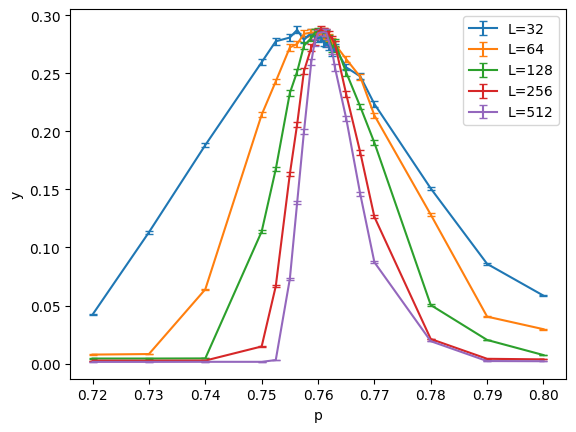

In [6]:
fig,ax=plt.subplots()

for L in [num_unit_cell_val * N_val for num_unit_cell_val in num_unit_cell_vals]:
    df_=decay_df.xs(L,level='L')['observations']
    y=df_.apply(np.mean)
    yerr=(df_.apply(np.std).sort_index())/np.sqrt(df_.apply(len))
    ax.errorbar(p_list, y,yerr, label=f'L={L}',capsize=3)
ax.legend()
ax.set_xlabel('p')
ax.set_ylabel('y')

# Finite size scaling

In [7]:
dc=DataCollapse(decay_df, p_='p',L_='L',params={},p_range=[min(p_list),max(p_list)],)

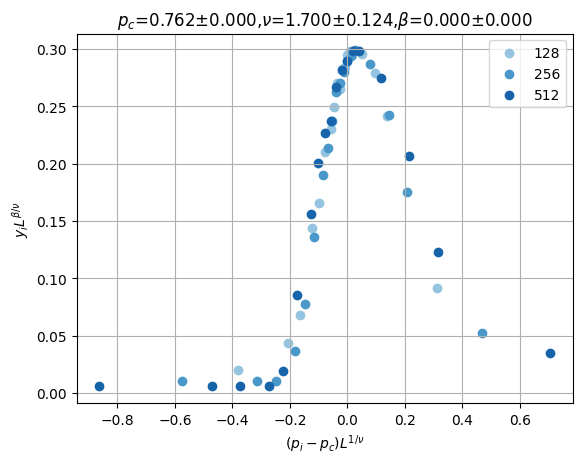

In [ ]:
res = dc.datacollapse(p_c=0.762,nu=1.699, p_c_vary=True,nu_vary=True, p_c_range=(0.760, 0.764), nu_range=(1.15, 1.7))
display(res)
dc.plot_data_collapse()

In [9]:
print(res.chisqr)

71834.02419142933


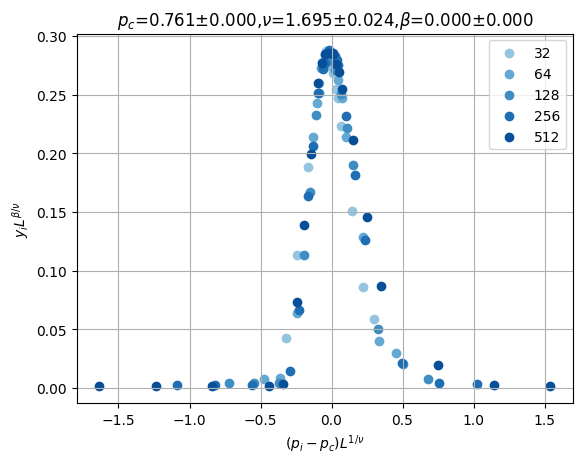

In [11]:
print(dc.p_c)
print(dc.nu)

0.7611731911387535
1.6947647328172284


# Long one

In [12]:
num_unit_cell_vals = [32, 64, 128]
N_val = 4
num_init_conds = 1000
a_vals = [0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.7525, 0.755, 0.7563, 0.7575, 0.7588,  0.7594, 0.76, 0.7605, 0.761, 0.7615, 0.762, 0.7625, 0.763, 0.765, 0.7675, 0.77, 0.78, 0.79, 0.8]

avraging_window = 1/128
avraging_window_name = f"{round(avraging_window,3)}".replace(".", "p")
print(avraging_window_name)

num_unit_cell_limits = [[8, 16, 32, 64, 128], [32, 64, 128]]
z_vals = [1.55, 1.6, 1.65, 1.7]
p_lims = [(0.72, 0.8), (0.74, 0.78)]


resultant_ac_vals = []
resultant_nu_vals = []
resultant_chi_sqr_vals = []
for z_val in z_vals:
    z_val_name = f"{z_val}".replace(".", "p")

    for num_unit_cell_vals in num_unit_cell_limits:

        def load_decay_data(path):
    
            data_dict = {}


            for L_val in [num_unit_cell_val * N_val for num_unit_cell_val in num_unit_cell_vals]:
                fname = f"lambda_var_per_a_N4_ar{str(min(a_vals)).replace(".", "p")}_{str(max(a_vals)).replace(".", "p")}_IC1000_L{int(L_val)}_z{z_val_name}_AW{avraging_window_name}.csv"
                df = pd.read_csv(os.path.join(path, fname))

                for _, row in df.iterrows():
                    a = row['a']
                    if a not in p_list:
                        continue
                    observations = row['observations']
                    std_observations = observations / math.sqrt((2*(num_init_conds)))
                    data_dict[(a, L_val)] = np.array([observations - std_observations, observations, observations + std_observations])

            # build MultiIndex DataFrame
            index = pd.MultiIndex.from_tuples(data_dict.keys(), names=['a','L'])
            df = pd.DataFrame({'observations': list(data_dict.values())}, index=index)
            return df

        for p_lim in p_lims:
            p_list = [a_val for a_val in a_vals if p_lim[0] <= a_val <= p_lim[1]]
            
        
            decay_df = load_decay_data(f"../../data_to_collapse/lambda_var_per_a/N{N_val}/SeveralAs/IC{num_init_conds}/SeveralLs/").sort_index(level='a').rename_axis(index={'a': 'p'})

            dc=DataCollapse(decay_df, p_='p',L_='L',params={},p_range=[min(p_list),max(p_list)],)
            res = dc.datacollapse(p_c=0.7612001,nu=1.699, p_c_vary=True,nu_vary=True, p_c_range=(0.760, 0.764), nu_range=(1.1, 3.0))
            resultant_ac_vals.append(dc.p_c)
            resultant_nu_vals.append(dc.nu)
            resultant_chi_sqr_vals.append(res.chisqr)


0p008


In [13]:
print('\n'.join(map(str, resultant_ac_vals)))

0.7607575229029362
0.7610938382778049
0.7602313241553584
0.7610953398290791
0.7609286962552638
0.7614360431476143
0.7601100568204153
0.7619382598090143
0.7611740135863492
0.761332535006992
0.7613272141703169
0.7626742093463704
0.761166866611406
0.7611162462746922
0.7618561114394931
0.7631302646539958


In [14]:
for nu in resultant_nu_vals:
    print(nu)

1.4961794382278917
1.7275422049687204
1.6932543142045273
1.8414351519707508
1.5748105562856276
1.814720575419012
1.7404389384308243
2.302152124221077
1.5943992554875264
1.5105796483767497
1.7827211275165915
2.2907131280481225
1.6247568622916146
1.5740542249127745
1.8398132482520921
2.4483235702636206


In [15]:
for chi_sqr in resultant_chi_sqr_vals:
    print(chi_sqr)

36602.2687650548
10744.37681445638
23198.52395878189
9177.035441302085
63968.058215752106
25051.486799172937
27761.070771444884
10928.723724428553
66284.16373370105
21432.655153463144
29379.084393625366
16148.65034051932
91761.67891964833
52300.58520947023
38616.48471876616
23588.303096236374
